# Libraries

In [1]:
import numpy as np
import pandas as pd
import json
import glob
import ast
import gzip
import os
import yaml
from tqdm import tqdm
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

# Functions

In [2]:
def filter_std_player_classes_monsters(df):
    # Convert the list of standard classes to a set for faster membership checks
    standard_classes = {
        'Barbarian', 'Bard', 'Cleric', 'Druid', 'Fighter', 'Monk', 
        'Paladin', 'Ranger', 'Rogue', 'Sorcerer', 'Warlock', 'Wizard', 'Blood Hunter'
    }

    def are_all_classes_standard(player_list_str):
        # Convert the string representation of the list only once
        player_list = ast.literal_eval(player_list_str)
        for player in player_list:
            # Iterate through each class information tuple
            for class_info in player['class']:
                # Check against the set of standard classes
                if class_info[0].strip() not in standard_classes:
                    return False
        return True
    
    # Filter rows based on player_info
    tqdm.pandas(desc="Filtering Players")
    df_filtered = df[df['player_info'].progress_apply(are_all_classes_standard)]
    
    # Filter rows based on monsters_info
    df_filtered = df_filtered[df_filtered['monsters_info'] != "[]"]

    # Filter rows based on party total hpratio
    df_filtered = df_filtered.dropna(subset=['party_total_hpratio'])
    
    # Filter rows based on party_total_precombat_hp
    df_filtered = df_filtered[df_filtered['party_total_precombat_hp']<1e10]

    # Filter rows based on party_total_precombat_hp
    df_filtered = df_filtered[df_filtered['party_total_postcombat_hp']<1e10]
    
    return df_filtered

# Workflow

In [3]:
combat_data_df = pd.read_csv("unfiltered_combat_data_df_03-30.csv")
print(combat_data_df.shape)

combat_data_filtered_df = filter_std_player_classes_monsters(combat_data_df)
print(combat_data_filtered_df.shape)

(24748, 44)


Filtering Players: 100%|██████████| 24748/24748 [00:06<00:00, 3741.37it/s]

(13774, 44)


In [4]:
csv_file_path = './filtered_combat_data_df_04-01.csv'
combat_data_filtered_df.to_csv(csv_file_path, index=False)

In [5]:
combat_data_filtered_df.columns

Index(['Unnamed: 0', 'combat_id', 'start_time', 'player_ids', 'player_info',
       'monsters_info', 'party_size', 'total_slots', 'total_max_slots',
       'party_classes_with_level', 'party_total_class_composition',
       'player_individual_hp_ratios', 'player_individual_ac',
       'player_individual_prof_bonus', 'player_individual_strength',
       'player_individual_dexterity', 'player_individual_constitution',
       'player_individual_intelligence', 'player_individual_wisdom',
       'player_individual_charisma', 'monster_types', 'monster_number',
       'monster_total_level', 'party_total_level', 'party_level1_spellslots',
       'party_level2_spellslots', 'party_level3_spellslots',
       'party_level4_spellslots', 'party_level5_spellslots',
       'party_level6_spellslots', 'party_level7_spellslots',
       'party_level8_spellslots', 'party_level9_spellslots', 'party_total_ac',
       'party_total_precombat_hp', 'party_total_postcombat_hp',
       'party_total_hpratio', 'part

In [6]:
df = pd.read_csv('./filtered_combat_data_df_04-01.csv').drop(columns=['Unnamed: 0'])

df = combat_data_filtered_df
# # Display the first few rows of the dataset
# display(df.head())
# # Display summary statistics
# display(df.describe())
# # Check for missing values
# #display(df.isnull().sum())

In [7]:
print(df.shape)


filtered = df.copy()

# Dropping party sizes below 10
filtered = filtered[filtered['party_size'] < 10]


rows_to_drop = []

# Dropping levels above 20
for index, row in filtered.iterrows():
    player_info = ast.literal_eval(row['player_info'])
    for d in player_info:
        total_lvl = sum(class_lvl[1] for class_lvl in d['class'])
        if total_lvl > 20:
            rows_to_drop.append(index)
            break  # No need to check further dicts in this row

filtered = filtered.drop(rows_to_drop)


rows_to_drop = []

# Droping those with either no hp ratio or hp's above 350
for index, row in filtered.iterrows():
    player_info = ast.literal_eval(row['player_info'])
    for d in player_info:
        # Corrected the check for None
        if d['hp_ratio'] is None:
            rows_to_drop.append(index)  # Appending index for consistency
            break  # Exit the loop after finding the condition met
        else:
            max_health = d['hp_ratio'][1]
            if max_health > 350:
                rows_to_drop.append(index)
                break  # No need to check further dicts in this row


rows_to_drop = []

# Dropping those either with no AC value(s) or AC's above 38
for index, row in filtered.iterrows():
    player_info = ast.literal_eval(row['player_info'])
    for d in player_info:
        # Corrected the check for None
        if d['ac'] is None:
            rows_to_drop.append(index)  # Appending index for consistency
            break  # Exit the loop after finding the condition met
        else:
            ac = d['ac']
            if ac > 38:
                rows_to_drop.append(index)
                break  # No need to check further dicts in this row


filtered = filtered.drop(rows_to_drop)


# Dropping who either do not have an ability score or if an ability score is above 22
stats = ['strength', 'dexterity', 'constitution', 'intelligence', 'wisdom', 'charisma']

rows_to_drop = []
for index, row in filtered.iterrows():
    player_info = ast.literal_eval(row['player_info'])
    for d in player_info:
        # Check if 'stats' is None
        if d['stats'] is None:
            rows_to_drop.append(index)  # Appending index for consistency
            break  # Exit the loop after finding the condition met
        else:
            # Iterate over the items in the 'stats' dictionary
            for key, value in d['stats'].items():
                if key in stats and value > 22:
                    rows_to_drop.append(index)
                    break  # Exit the loop after finding a stat greater than 22


filtered = filtered.drop(rows_to_drop)

filtered.shape

(13774, 44)


(11507, 44)

In [9]:
# Adding player to monster and monster to player ratios 
filtered['player_monster_ratio'] = filtered['party_size']/filtered['monster_number']

filtered['monster_player_ratio'] = filtered['monster_number']/filtered['party_size']


In [64]:
num_features = filtered.select_dtypes(include=['int64', 'float64']).columns.drop(['start_time'])
print(num_features)

Index(['party_size', 'monster_number', 'monster_total_level',
       'party_total_level', 'party_level1_spellslots',
       'party_level2_spellslots', 'party_level3_spellslots',
       'party_level4_spellslots', 'party_level5_spellslots',
       'party_level6_spellslots', 'party_level7_spellslots',
       'party_level8_spellslots', 'party_level9_spellslots', 'party_total_ac',
       'party_total_precombat_hp', 'party_total_postcombat_hp',
       'party_total_hpratio', 'party_total_prof_bonus', 'party_total_strength',
       'party_total_dexterity', 'party_total_constitution',
       'party_total_intelligence', 'party_total_wisdom',
       'party_total_charisma', 'player_monster_ratio', 'monster_player_ratio'],
      dtype='object')


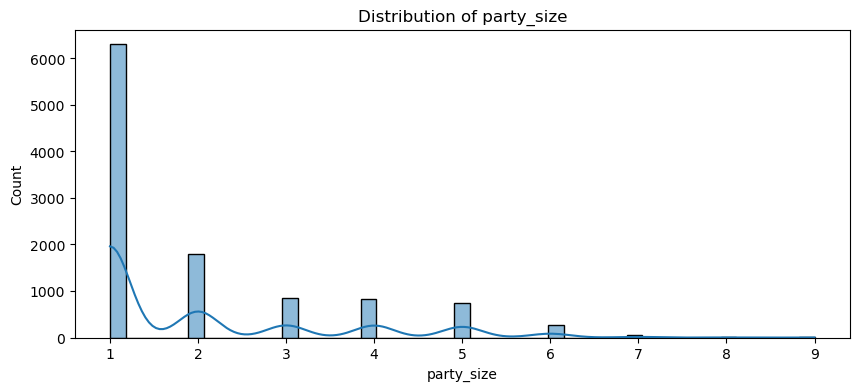

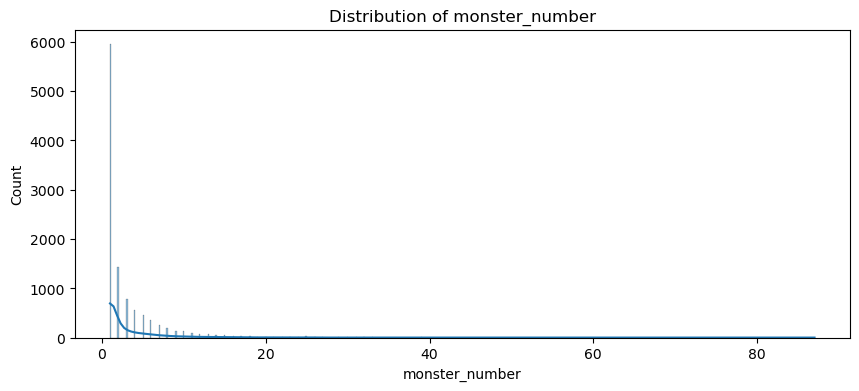

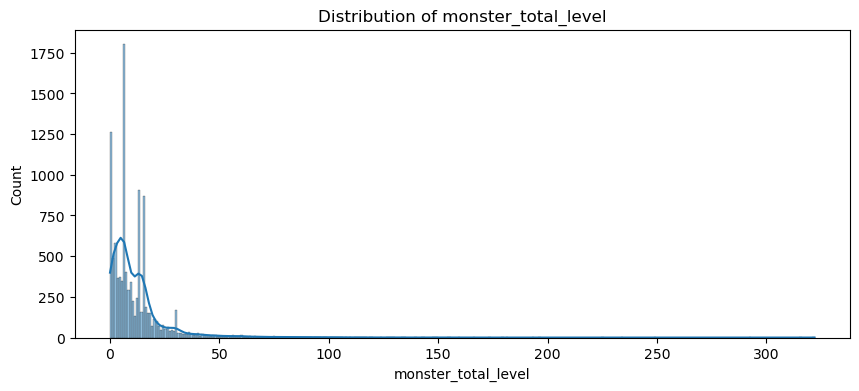

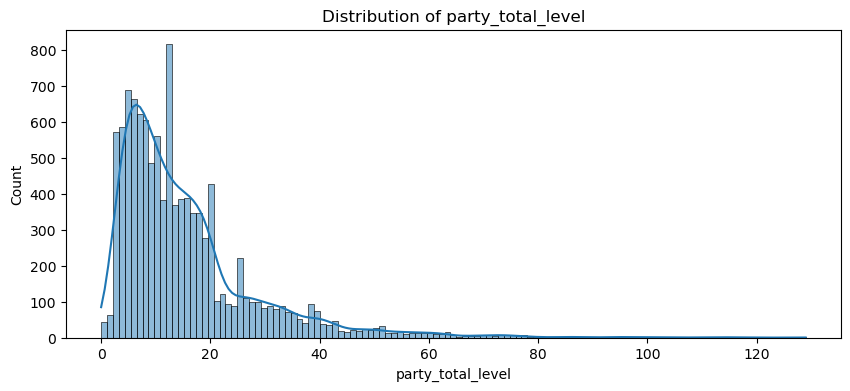

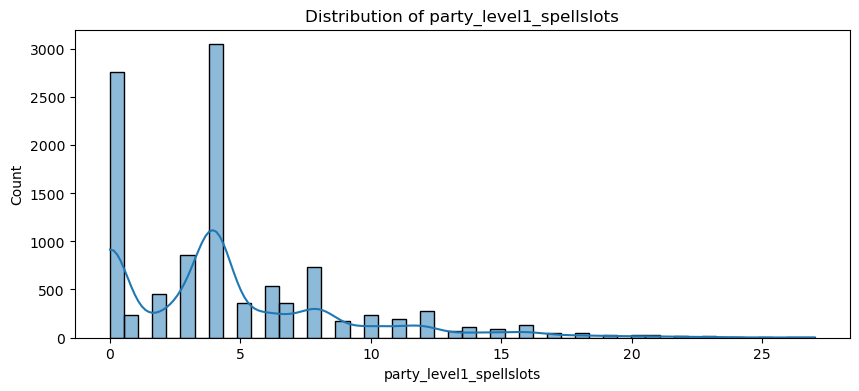

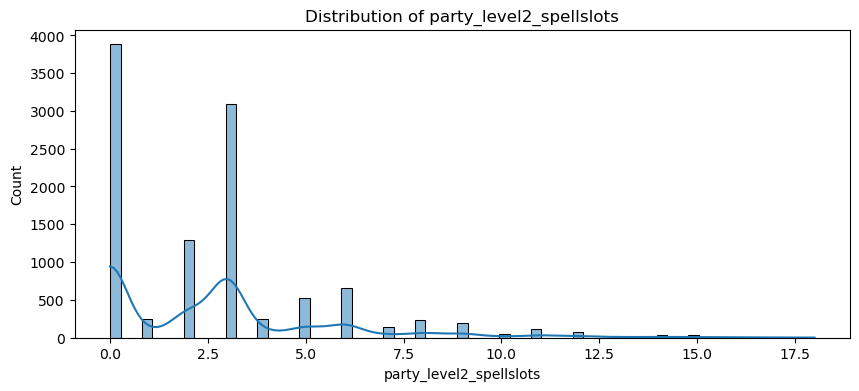

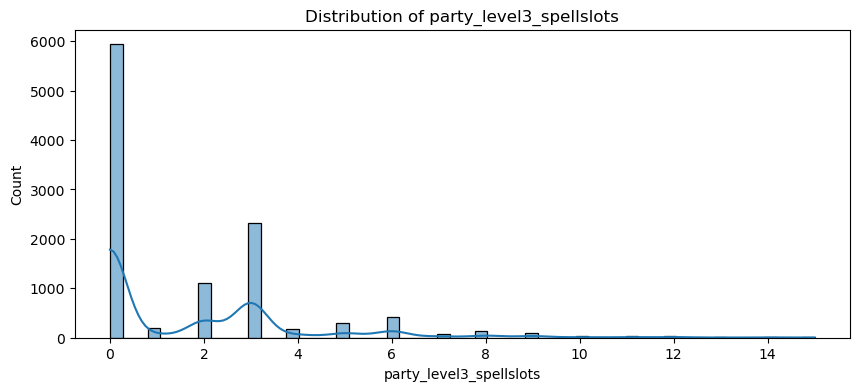

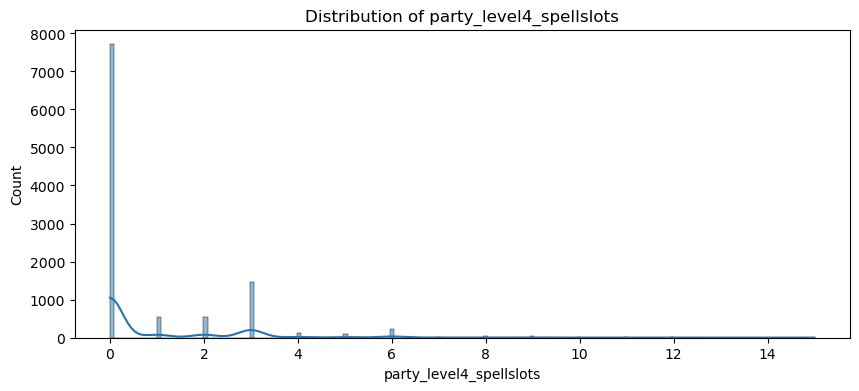

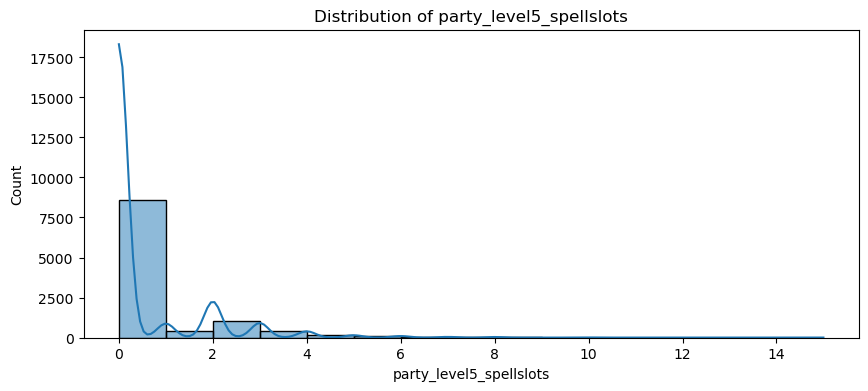

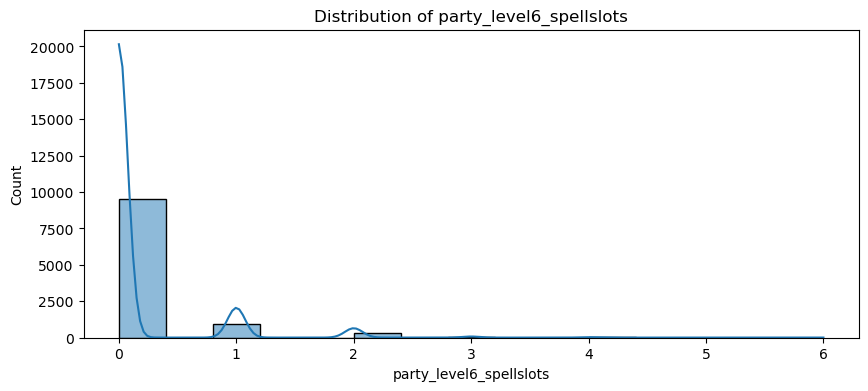

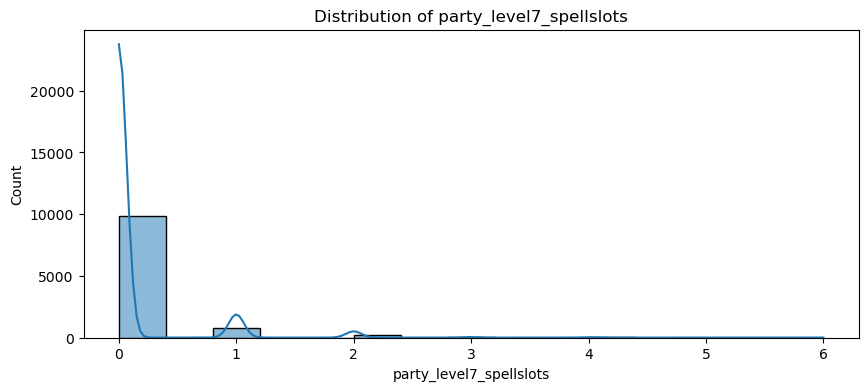

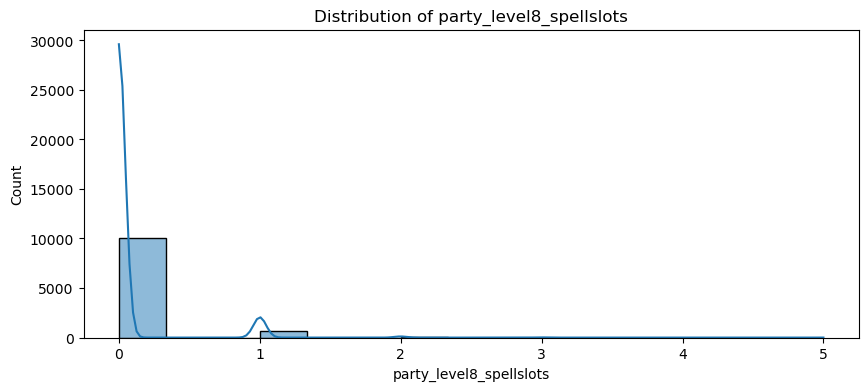

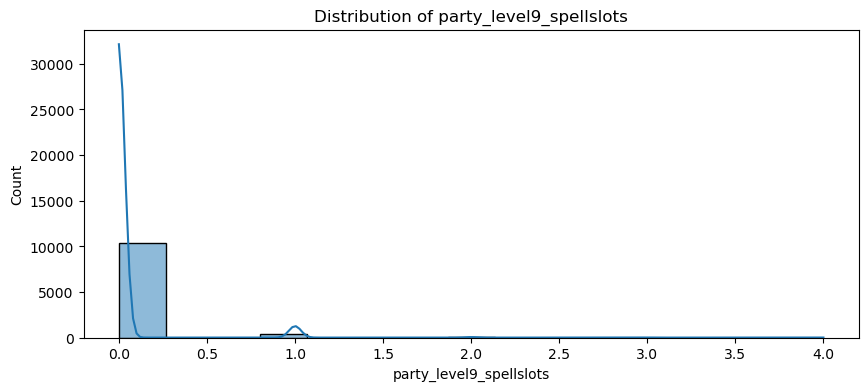

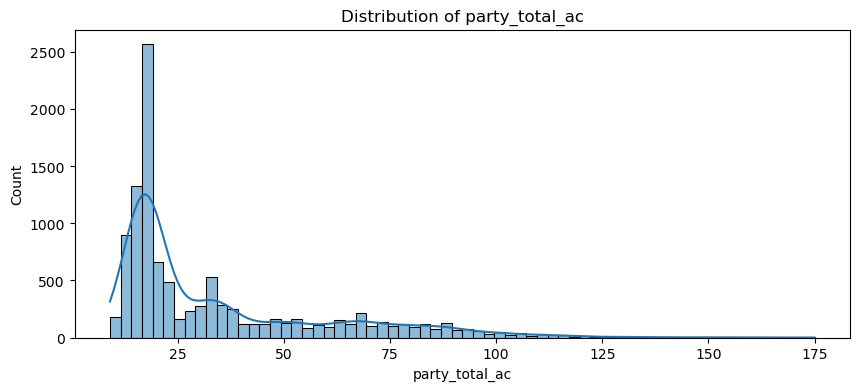

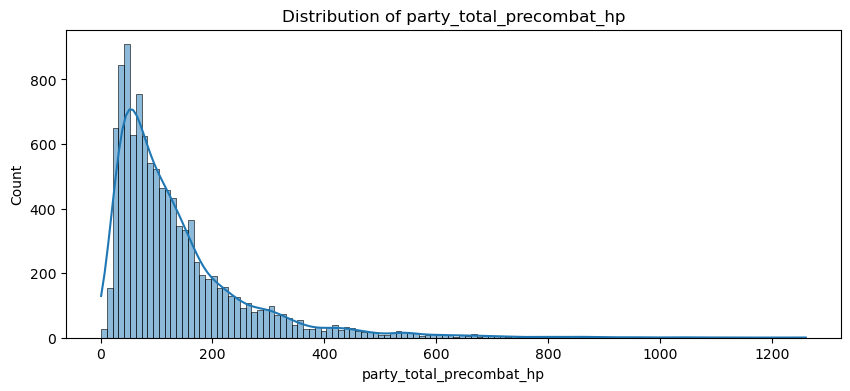

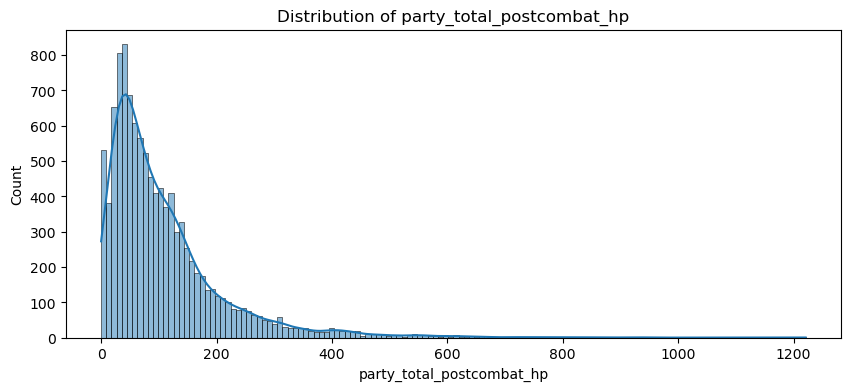

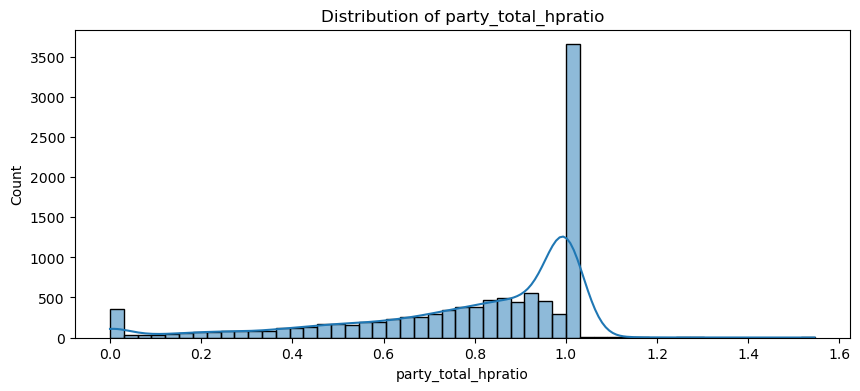

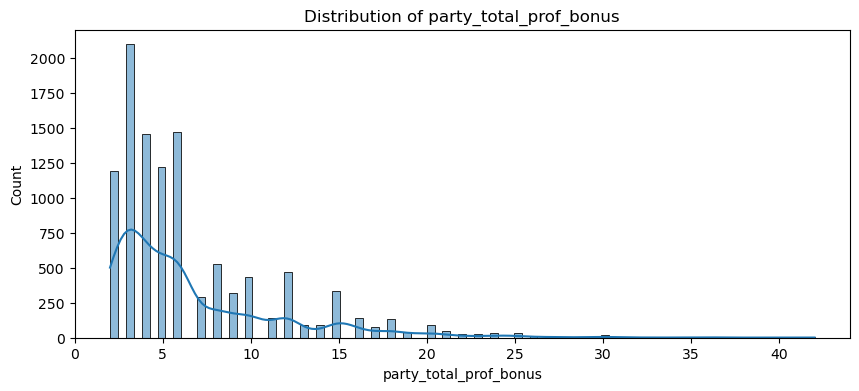

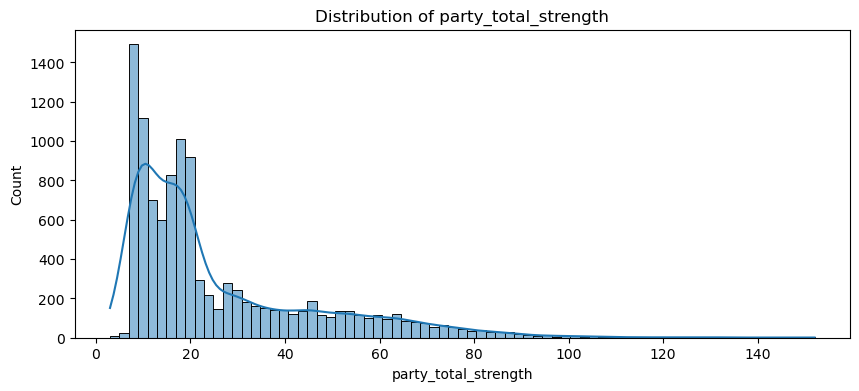

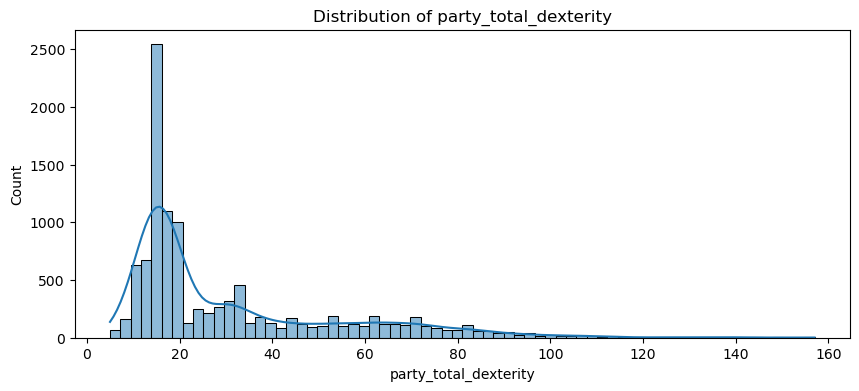

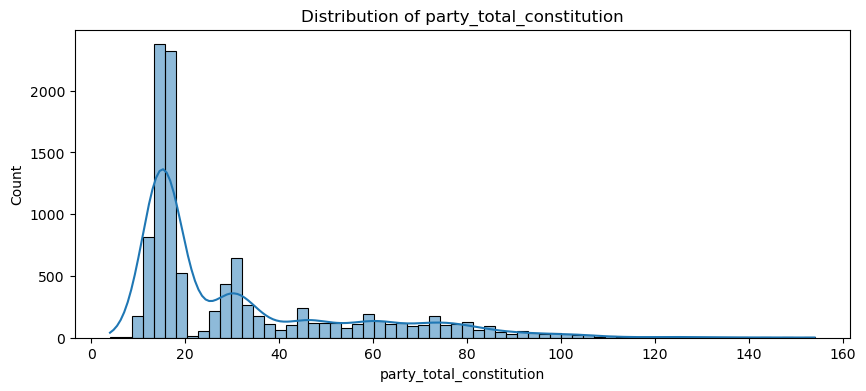

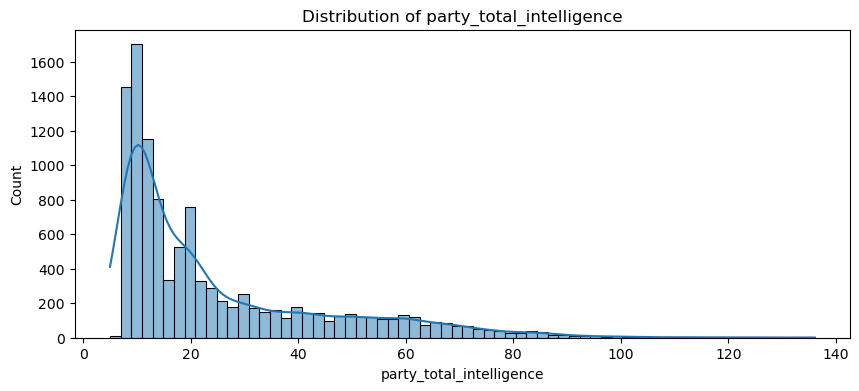

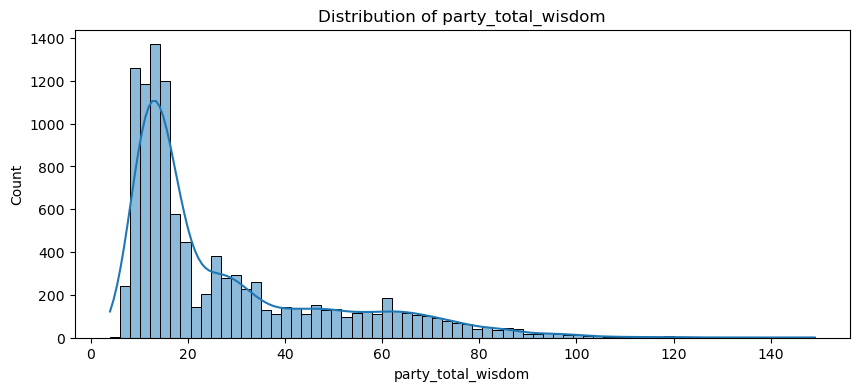

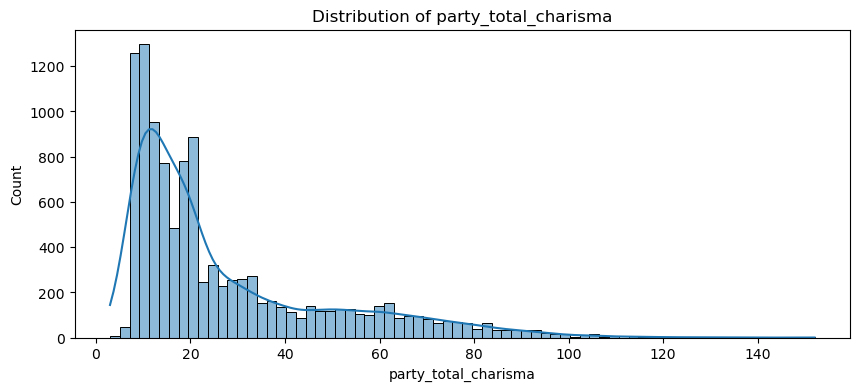

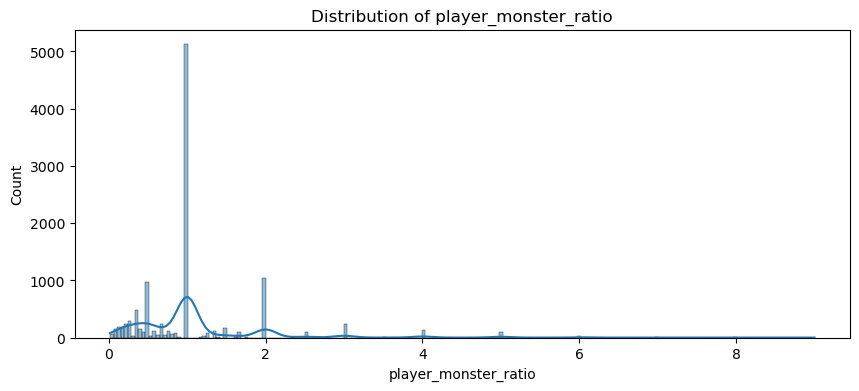

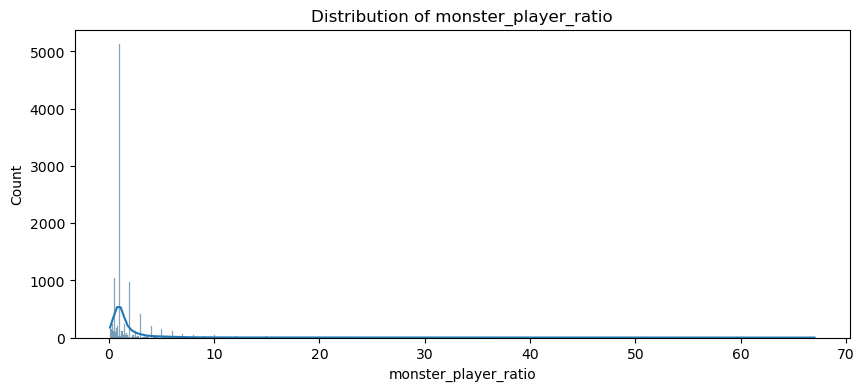

In [65]:
# Histograms for numerical features
for feature in num_features:
    try:
        plt.figure(figsize=(10, 4))
        sns.histplot(filtered[feature], kde=True)
        plt.title(f'Distribution of {feature}')
        plt.show()
    except:
        print(f"Failed {feature}")


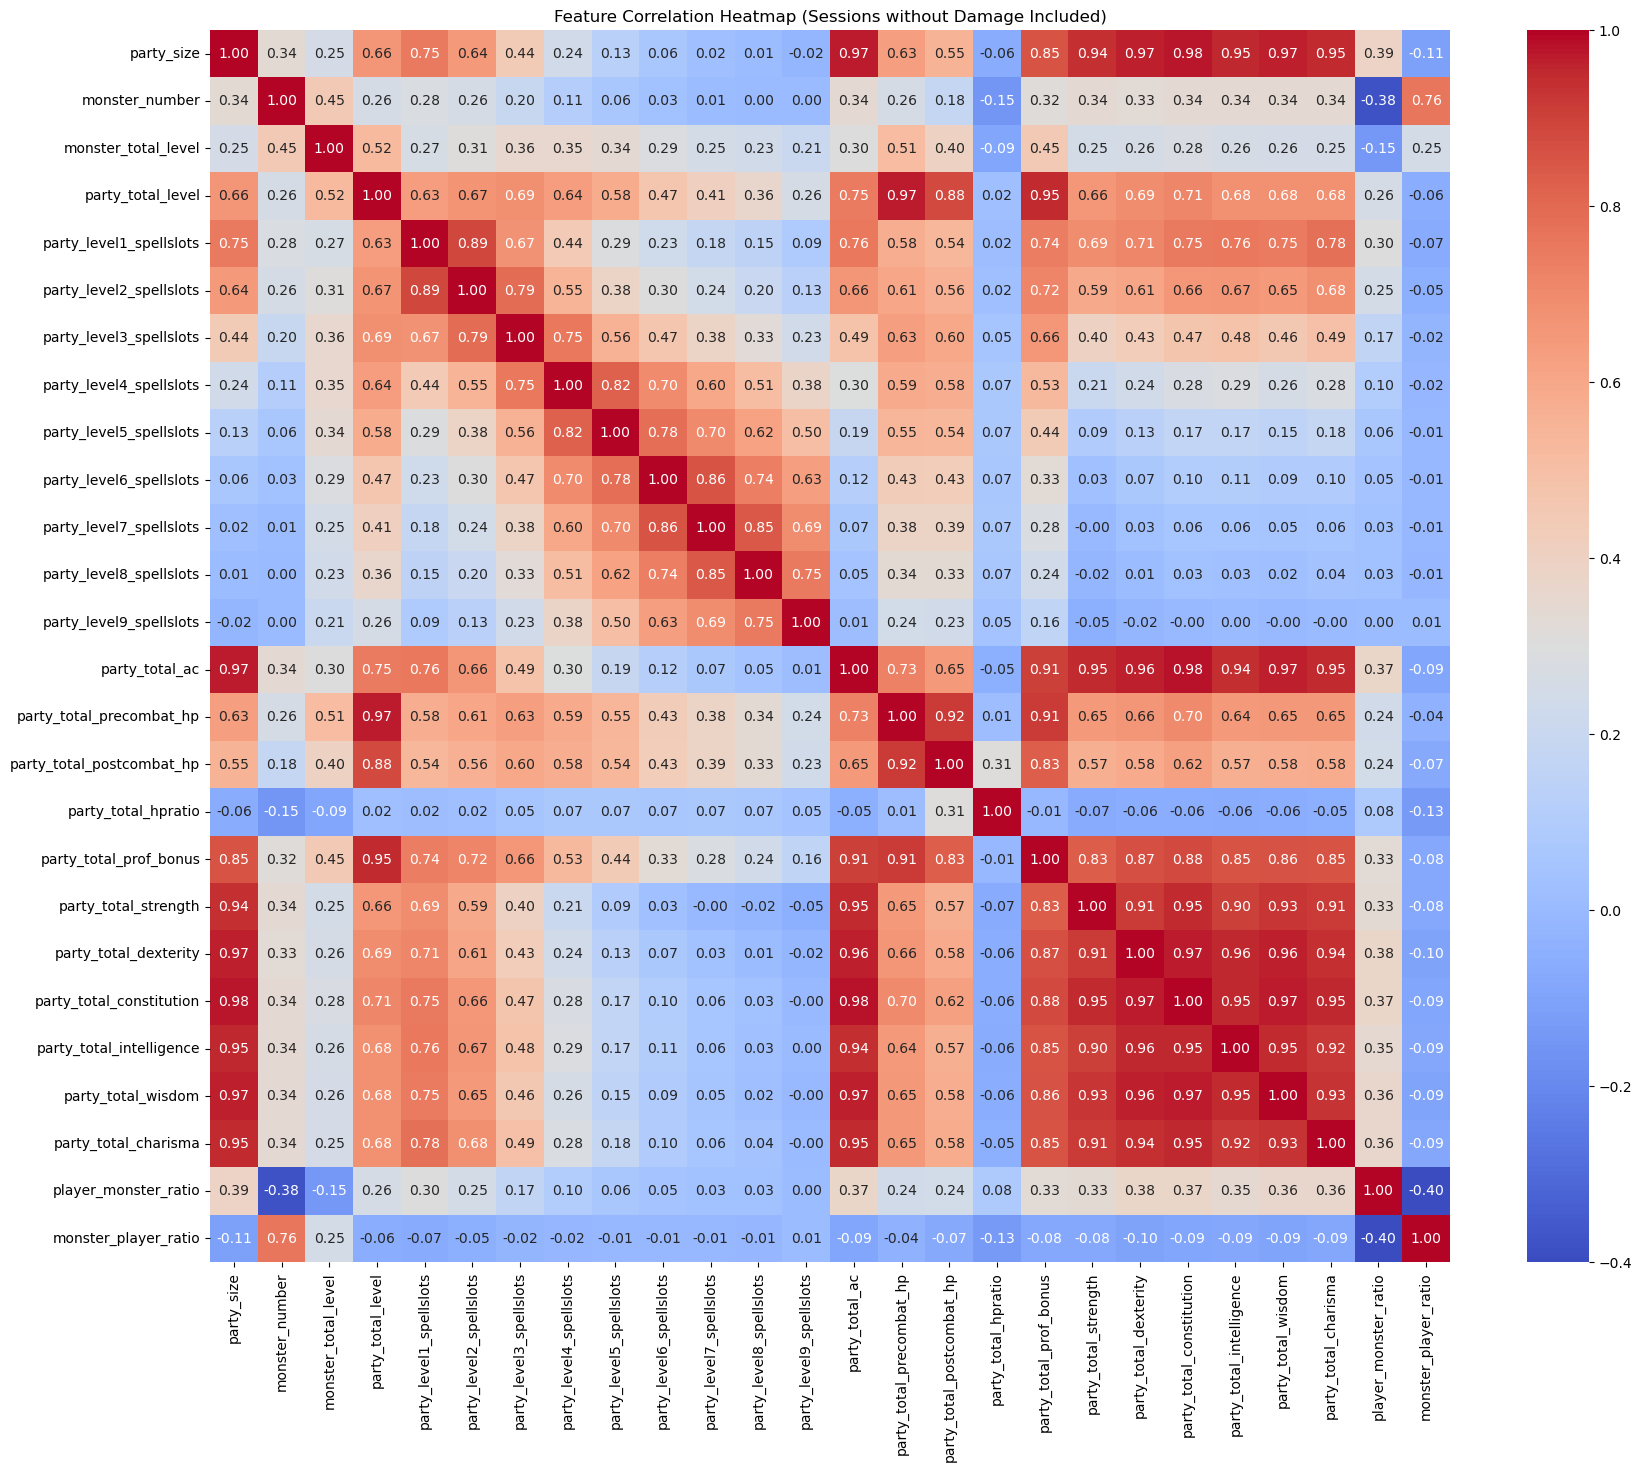

In [73]:
# Correlation heatmap for numerical features including sessions with no damage
corr = filtered[num_features].corr()
corr_filled = corr#corr.fillna(0)

plt.figure(figsize=(20, 16))
sns.heatmap(corr_filled, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap (Sessions without Damage Included)')
plt.savefig("corr_no_dmg_included.png", format='png')

plt.show()


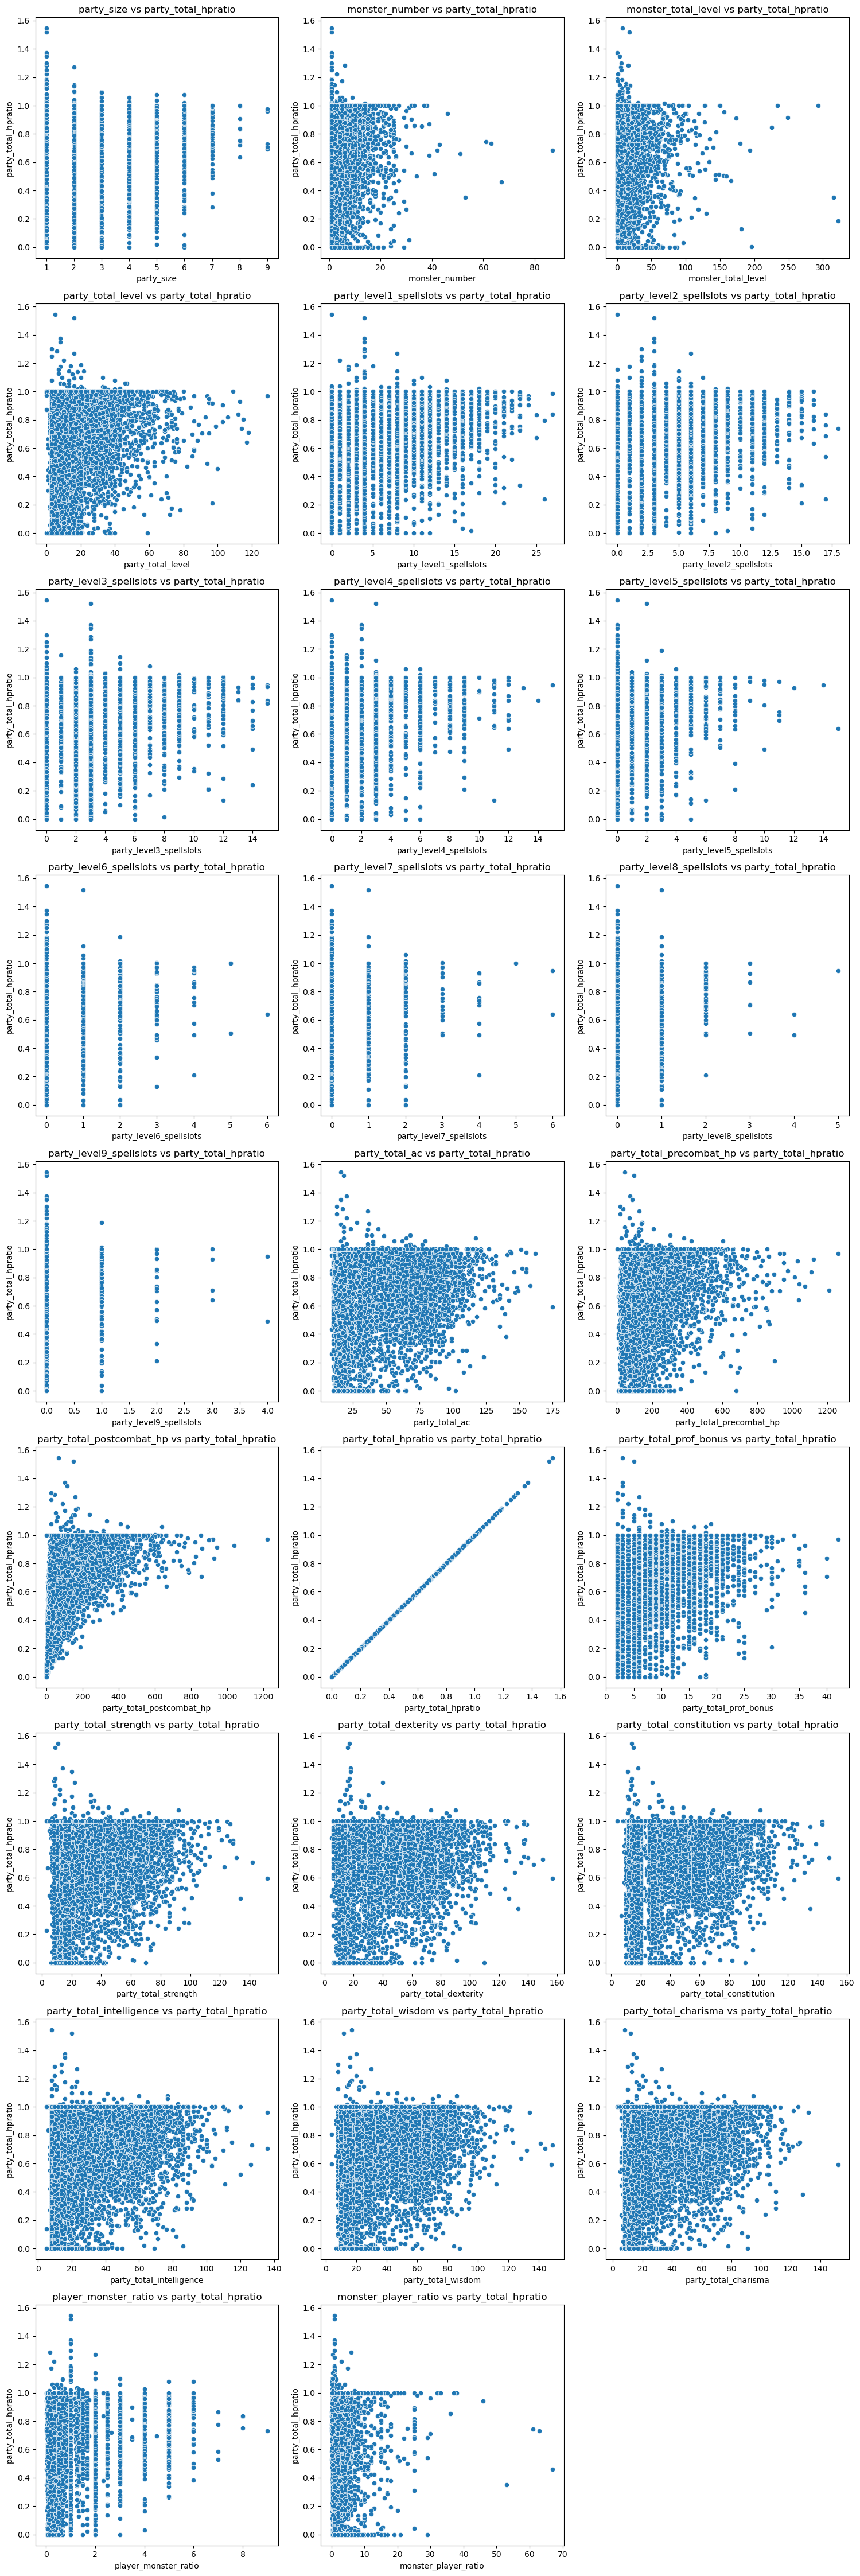

In [75]:
# Plotting all the numercial columns as a function of hp ratio
target_column = 'party_total_hpratio'

# Determine the number of plots and calculate the grid size (rows x columns)
num_plots = len(num_features)
n_cols = 3  # Number of columns in the figure
n_rows = (num_plots + n_cols - 1) // n_cols  # Calculate rows needed, rounding up

# Create a figure with subplots arranged in a grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))

# Flatten the axes array for easy iteration, in case of a 2D axes array
axes = axes.flatten()

# Loop through the features and create a plot for each
for i, feature in enumerate(num_features):
    sns.scatterplot(x=filtered[feature], y=filtered[target_column], ax=axes[i])
    axes[i].set_title(f'{feature} vs {target_column}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target_column)

# Turn off any unused subplots
for j in range(i + 1, n_cols * n_rows):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()